# ESPCN Resolution

As final models the following 3 algorithms were chosen:
* FaceNet512
* ArcFace
* VGG-Face

In [1]:
%cd /tf/notebooks

/tf/notebooks


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import itertools
from itertools import permutations
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
from PIL import Image
from sklearn.metrics import roc_auc_score, accuracy_score
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as st
import tensorflow as tf

from utils import (
    calculate_confidence_interval, calculate_performance_per_threshold,
    count_distances,plot_performance_per_threshold,
    get_metric_comparision, plot_score_distribution,
    perform_significance_test, calculate_distribution_difference,plot_face_heatmap
)
from skimage.restoration import denoise_bilateral


import cv2
from deepface import DeepFace


In [4]:
def load_image(shape,path,preprocessing = None):
    if preprocessing is not None:
        img = Image.open(path).resize(shape)
        img = np.array(img)
        img = preprocessing(img)
    else:
        img = Image.open(path).resize(shape)
        img = np.array(img)
    return img

In [5]:
sr = cv2.dnn_superres.DnnSuperResImpl_create()
path = "resolution_models/ESPCN_x2.pb"
sr.readModel(path)
sr.setModel("espcn", 2)

def increase_espcn_resolution_and_denoise(img):  
    img = sr.upsample(img)
    img = cv2.fastNlMeansDenoisingColored(img,  None, 10, 10, 7, 21)
    return img

## Example

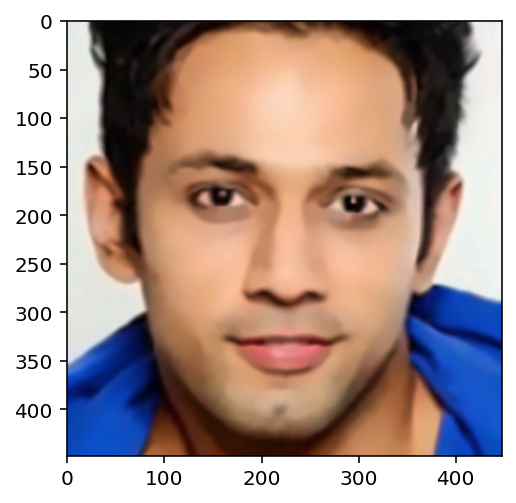

In [6]:
indian_img_path = 'data/race_per_7000/Indian/m.0l8nmsx/000016_00@hi.jpg'
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = increase_espcn_resolution_and_denoise)
plt.imshow(indian_img);

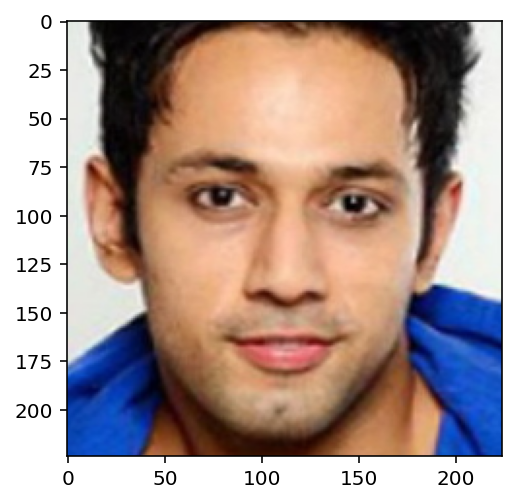

In [7]:
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = None)
plt.imshow(indian_img);

# Evaluation

## Performance comparison

Due to the balanced target labels (50% pairs and 50% non-pairs) we chose to use Accuracz and AUROC as evaluation metrics.

### Facenet512

In [8]:
facenet_model = "facenet_combined"

In [9]:
facenet_summary = get_metric_comparision(facenet_model, roc_auc_score)

facenet_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.901452,0.900288,0.902615
0,Asian,0.879876,0.878596,0.881157
0,African,0.846604,0.845112,0.848095
0,Caucasian,0.827635,0.826027,0.829243


In [10]:
facenet_summary = get_metric_comparision(facenet_model, accuracy_score)

facenet_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Asian,0.810760,0.809295,0.812225
0,Indian,0.810083,0.808706,0.811460
0,African,0.761257,0.759773,0.762741
0,Caucasian,0.690583,0.688838,0.692329


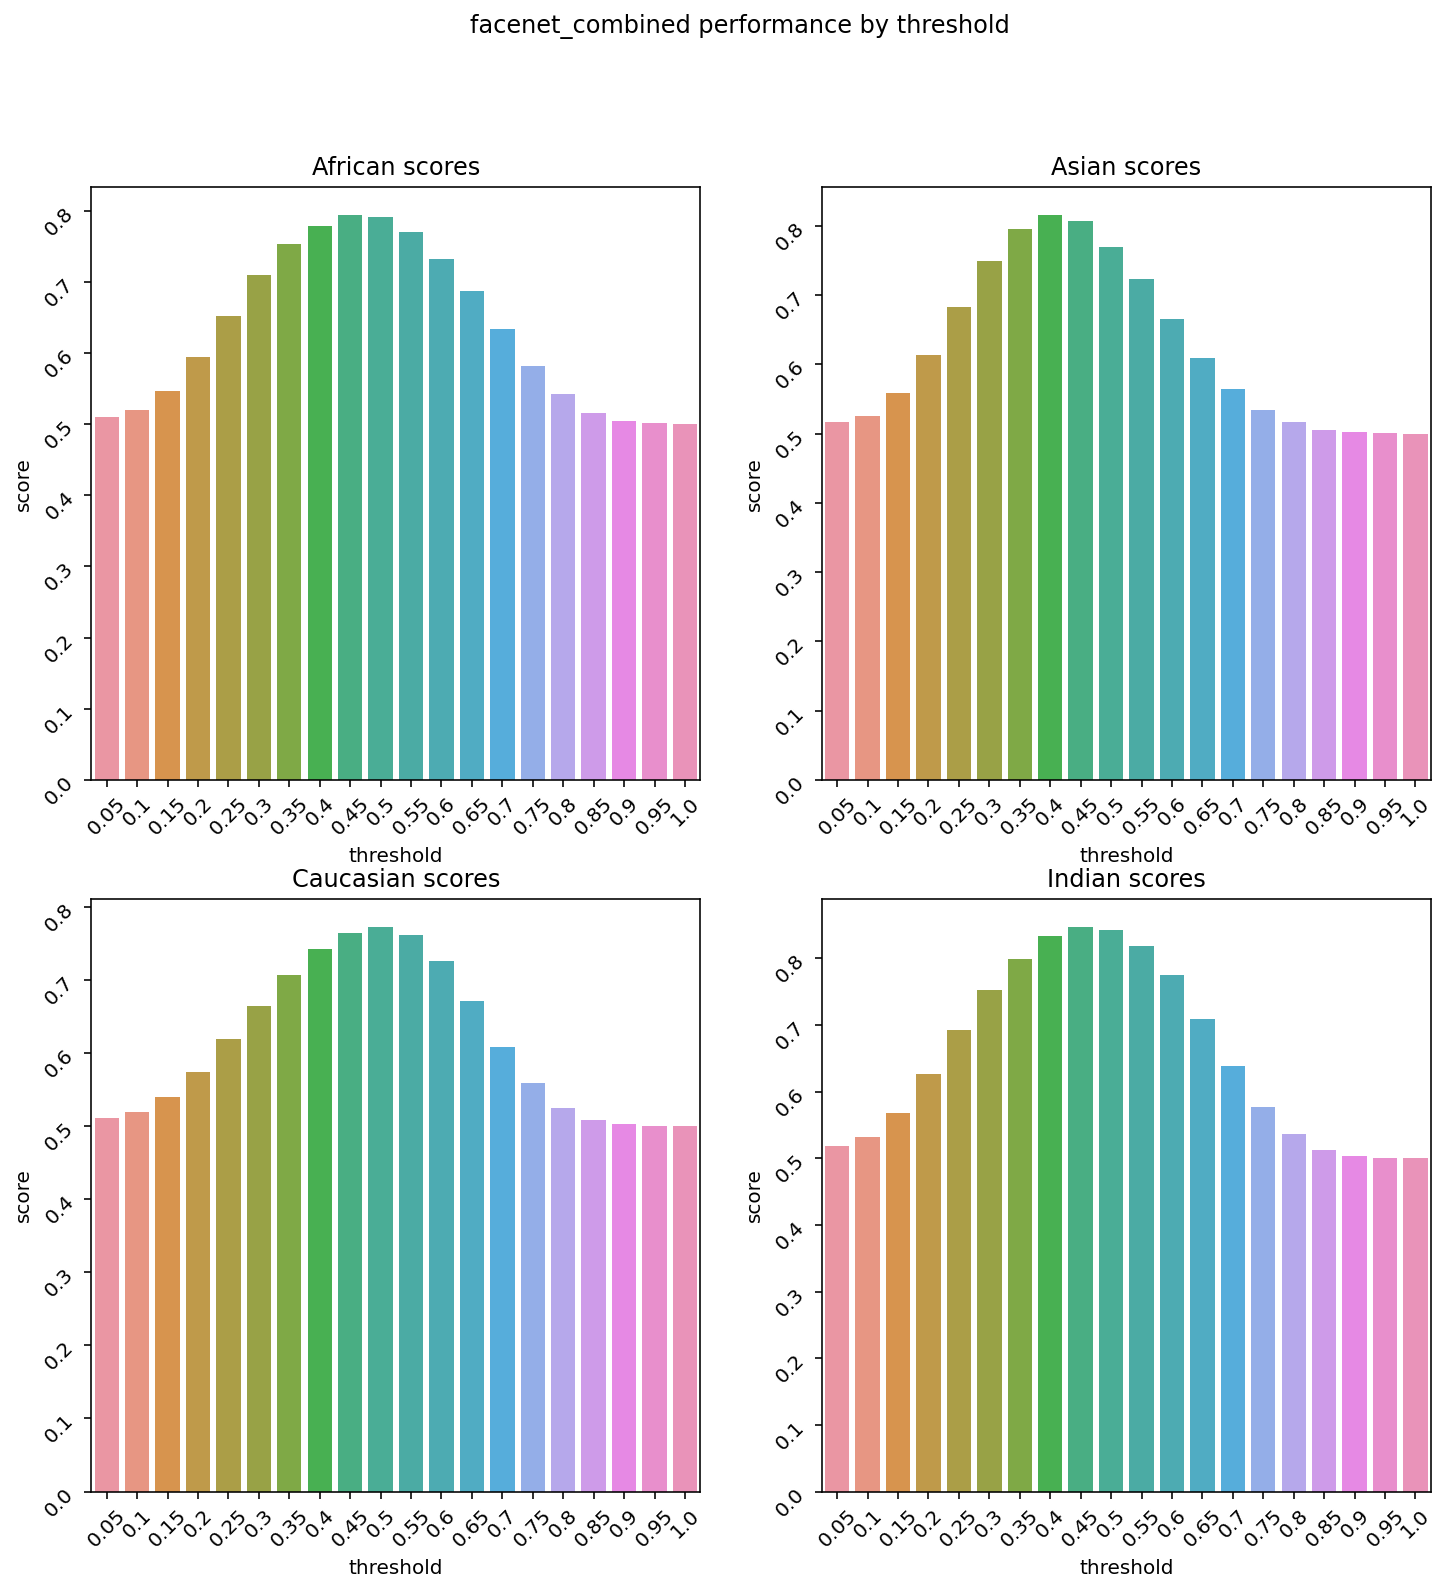

In [11]:
plot_performance_per_threshold(facenet_model)

**Result**:
* Significant performance drop from Indian to Asian (appx. 10% AUROC and accuracy)
* Interestingly Indian lower CI is higher than higher CI of Caucasians
* CI of Asians is also wider
* Best performing thresholds differ. Especially Asian which tells us that one threshold might not make sense

### VGG-Face

In [12]:
vgg_face_model = "vgg_face_combined"


In [13]:
vgg_summary = get_metric_comparision(vgg_face_model, roc_auc_score)

vgg_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.840598,0.839234,0.841963
0,Asian,0.793916,0.792362,0.795469
0,African,0.733151,0.731359,0.734943
0,Caucasian,0.717626,0.715871,0.719381


In [14]:
vgg_summary = get_metric_comparision(vgg_face_model, accuracy_score)

vgg_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.738327,0.736882,0.739771
0,Caucasian,0.675450,0.673767,0.677133
0,African,0.652757,0.651165,0.654348
0,Asian,0.649480,0.647756,0.651204


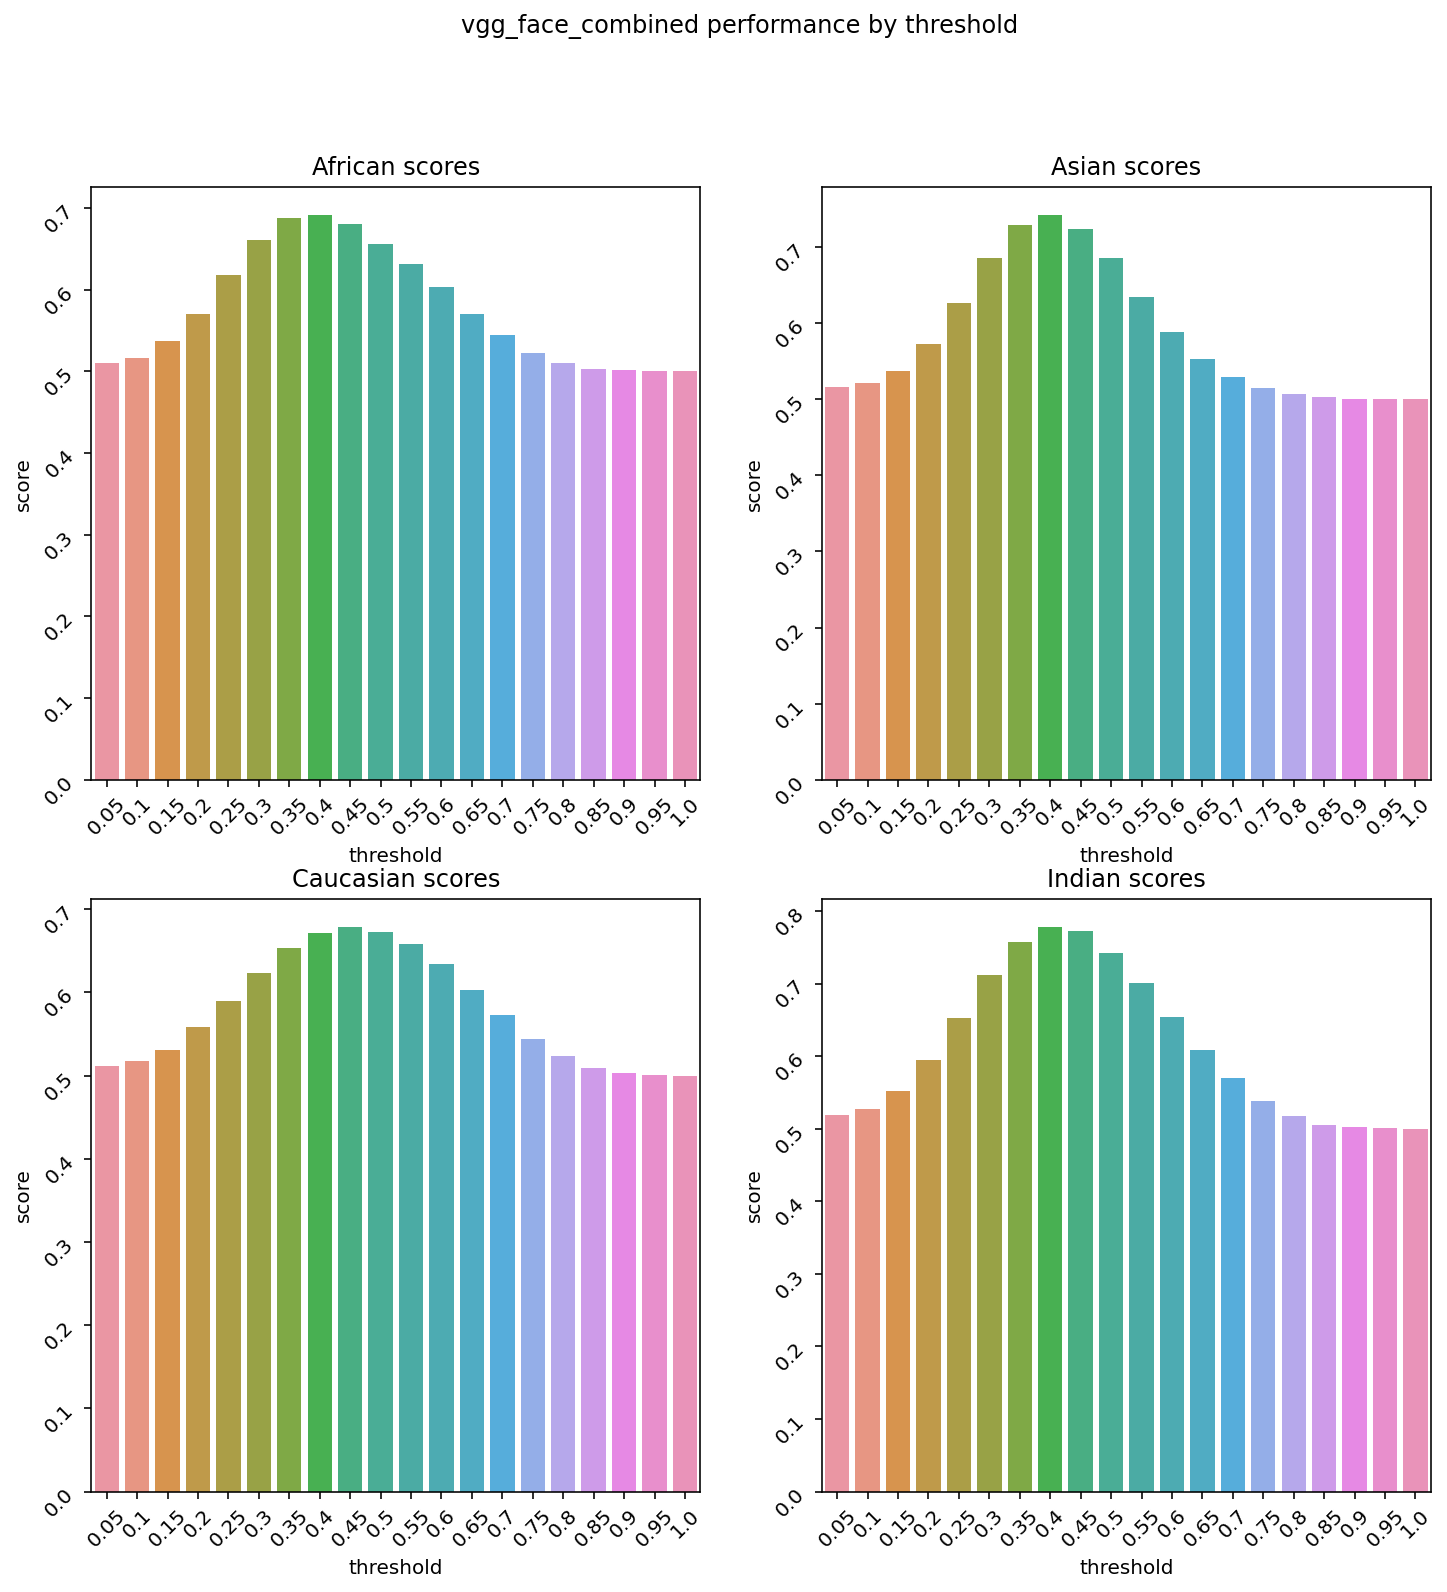

In [15]:
plot_performance_per_threshold(vgg_face_model)

**Result**:
* Overall performance is worse than with FaceNet512
* Mean performance is though only 6% difference between highest and lowest, indicating more fairness
* Varying performance for Asians again
* Partly overlapping CIs
* Thresholds are more fair which is reflected in the fair performance

### ArcFace

In [16]:
arcface_model = "arcface_smaller_espcn_resolution"

In [17]:
arcface_summary = get_metric_comparision(arcface_model, roc_auc_score)

arcface_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.784076,0.782307,0.785846
0,Asian,0.775264,0.773422,0.777106
0,African,0.655565,0.653458,0.657673
0,Caucasian,0.631536,0.629550,0.633521


In [18]:
arcface_summary = get_metric_comparision(arcface_model, accuracy_score)

arcface_summary.sort_values('mean', ascending=False)

,race,mean,lower_ci,higher_ci
0,Indian,0.624377,0.622560,0.626194
0,Asian,0.612757,0.610948,0.614565
0,African,0.571953,0.569997,0.573910
0,Caucasian,0.568687,0.567022,0.570352


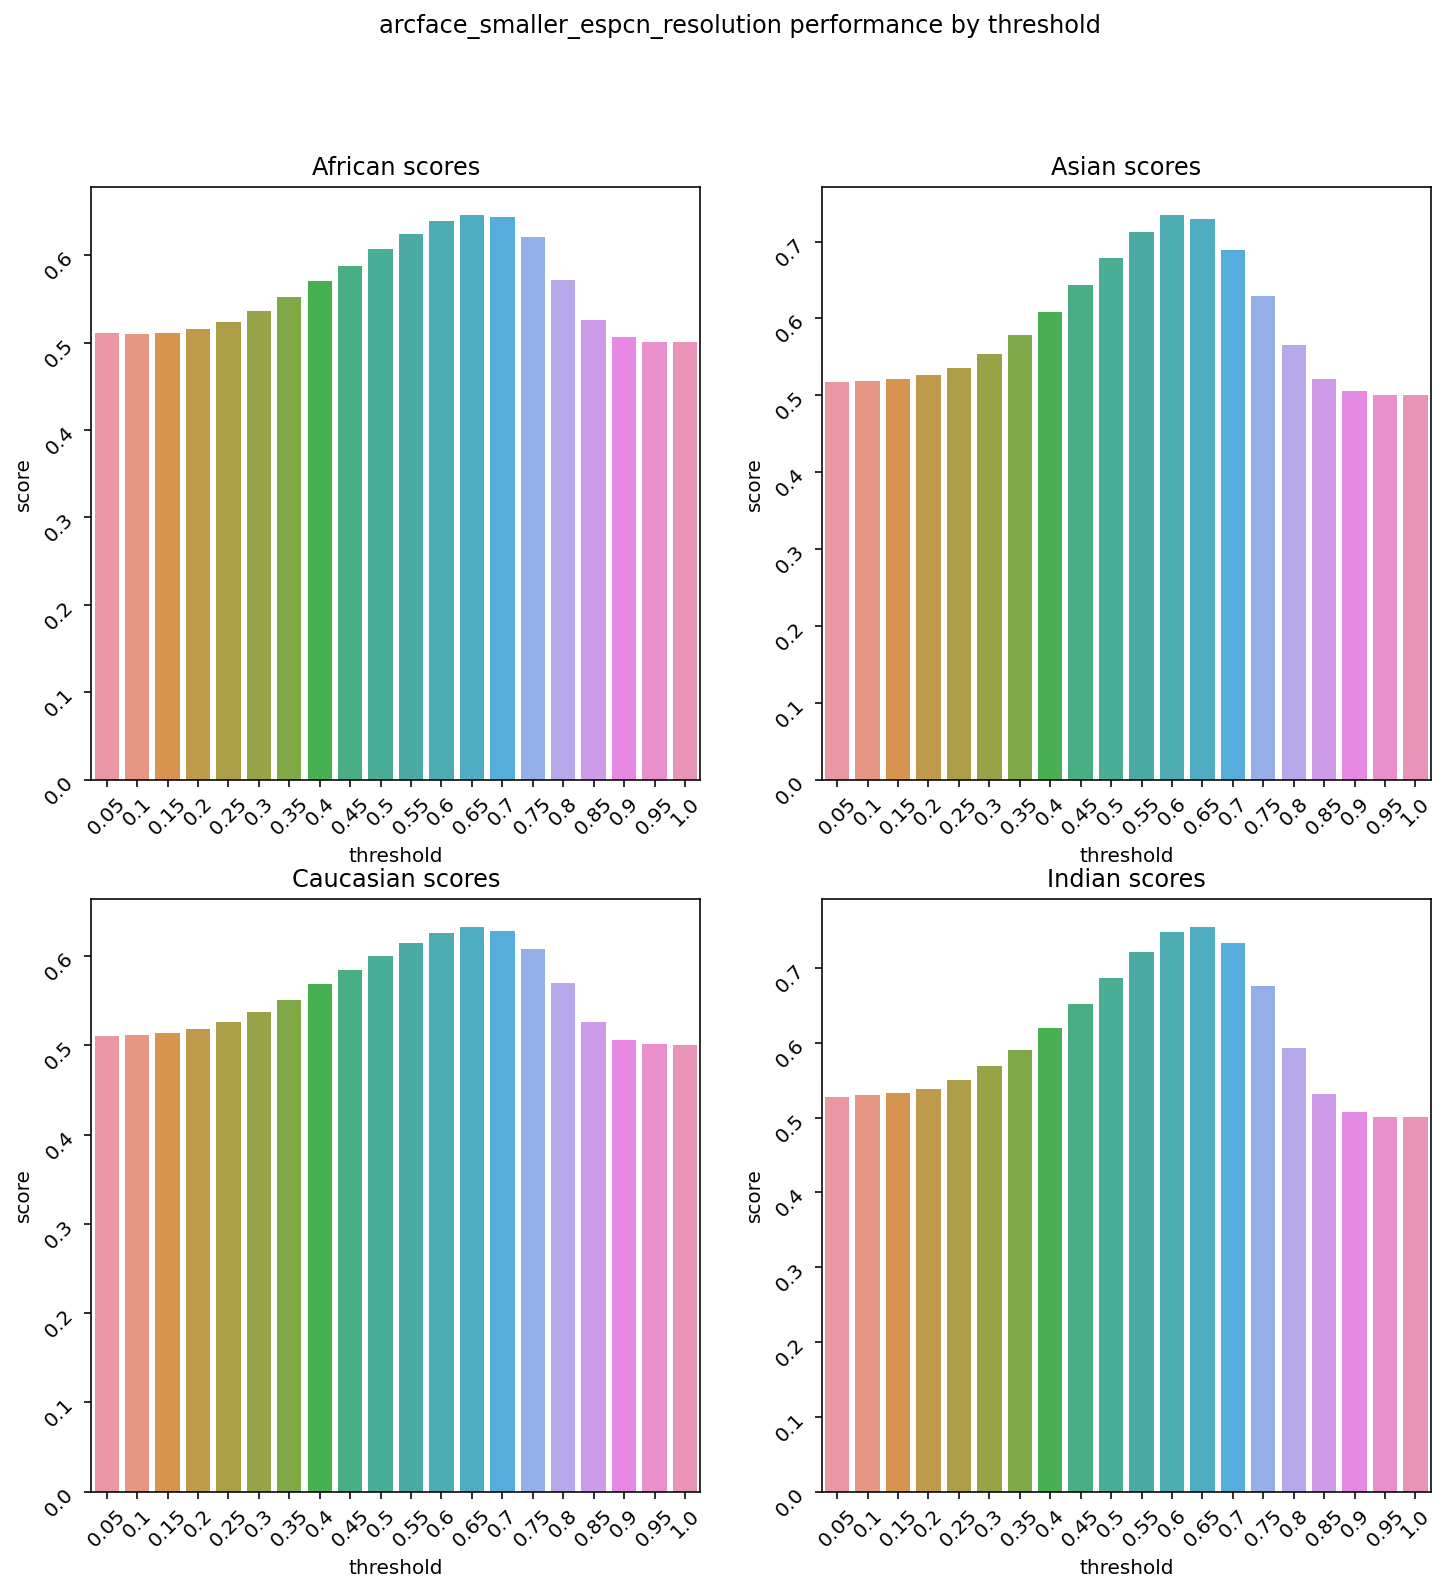

In [19]:
plot_performance_per_threshold(arcface_model)

**Result**:
* Worst overall performance
* Only 5% decrease between best and worst which seems to be fairer
* Asians again wide CI compared to e.g. Caucasian
* Best thresholds is shifted to the right but rather similar

## Distance distribution

This is the distribution of the predicted distance between the pairs. In a first plot they will be generally visualised and then paised on pairs vs. non-pairs.
An ideal model would predict two peaking curves on the outer ends of the plot indicating good discrimination.

### FaceNet512

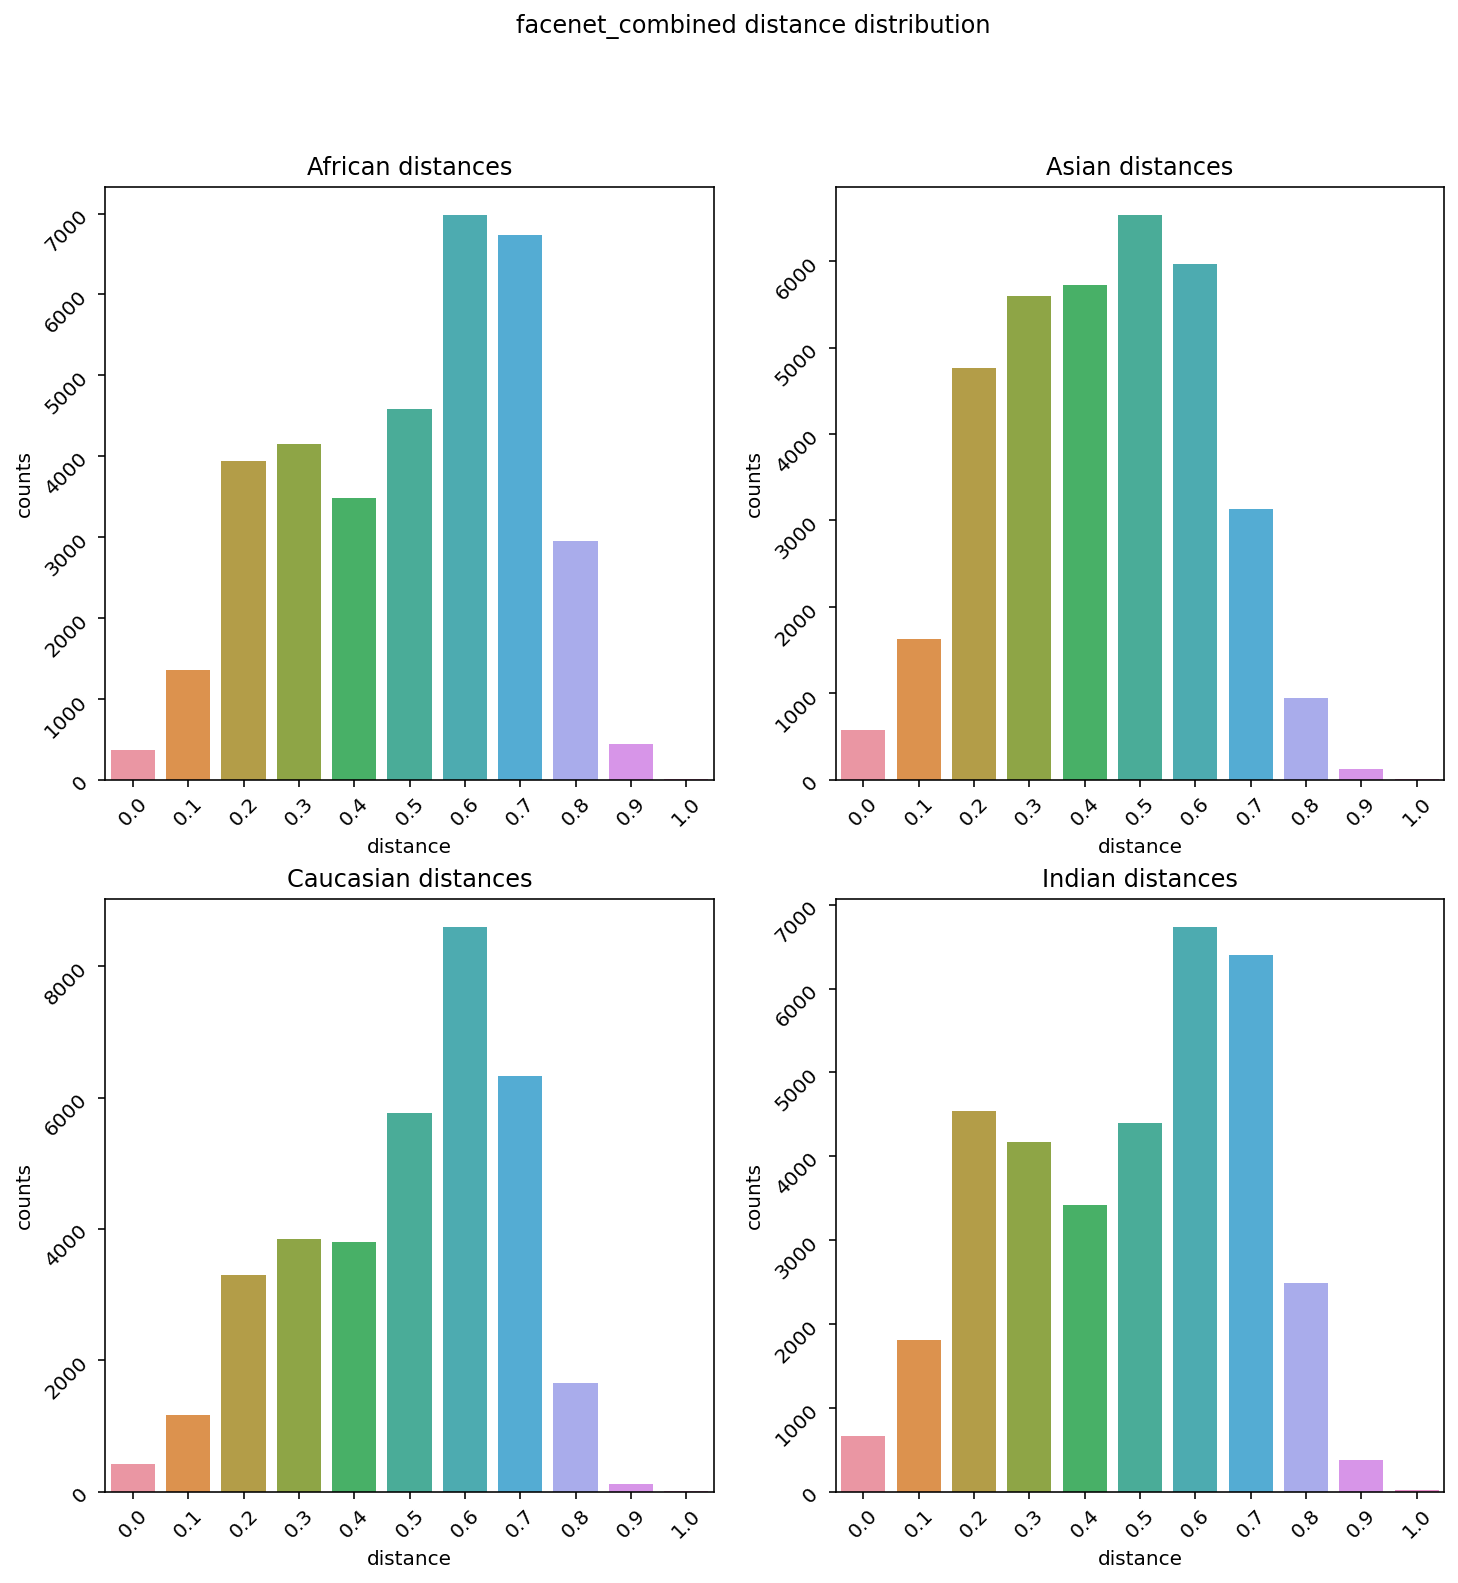

In [20]:
plot_score_distribution(facenet_model)

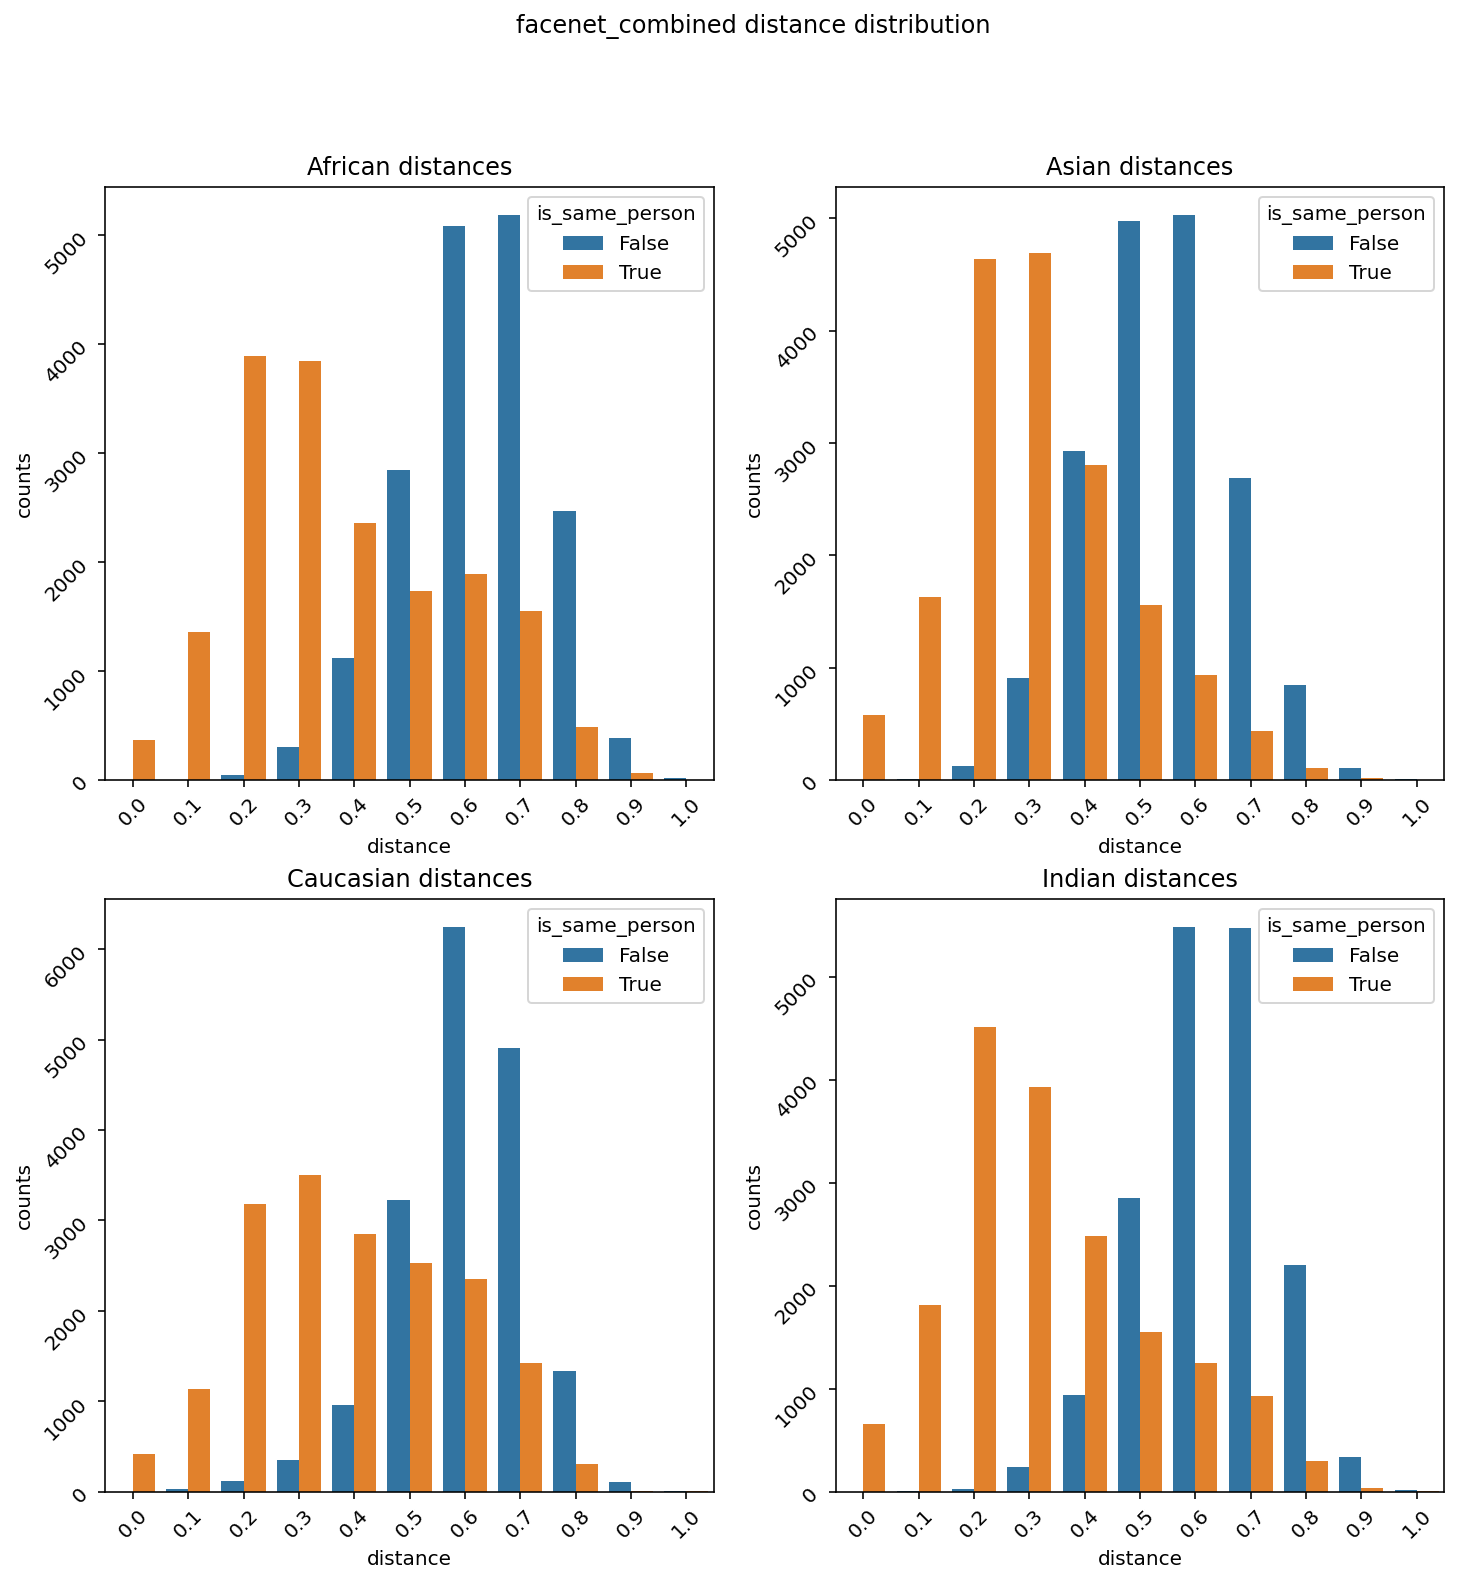

In [21]:
plot_score_distribution(facenet_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [22]:
print("Asian difference in mean:",calculate_distribution_difference(facenet_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(facenet_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(facenet_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(facenet_model,"Indian"))

Asian difference in mean: -0.33060245799013216
African difference in mean: -0.36256527152077656
Caucasian difference in mean: -0.3413247290827276
Indian difference in mean: -0.4291621584276778


**Results**:
* Only the Asian model does not show two spiking parts. This means the distinction is done very badly. For the three other spikes are at least visible.
* All models have heavy overlaps which means there is always a trade off when choosing a threshold.
* Only the asian threshold is shifted to the left.

### VGG-Face


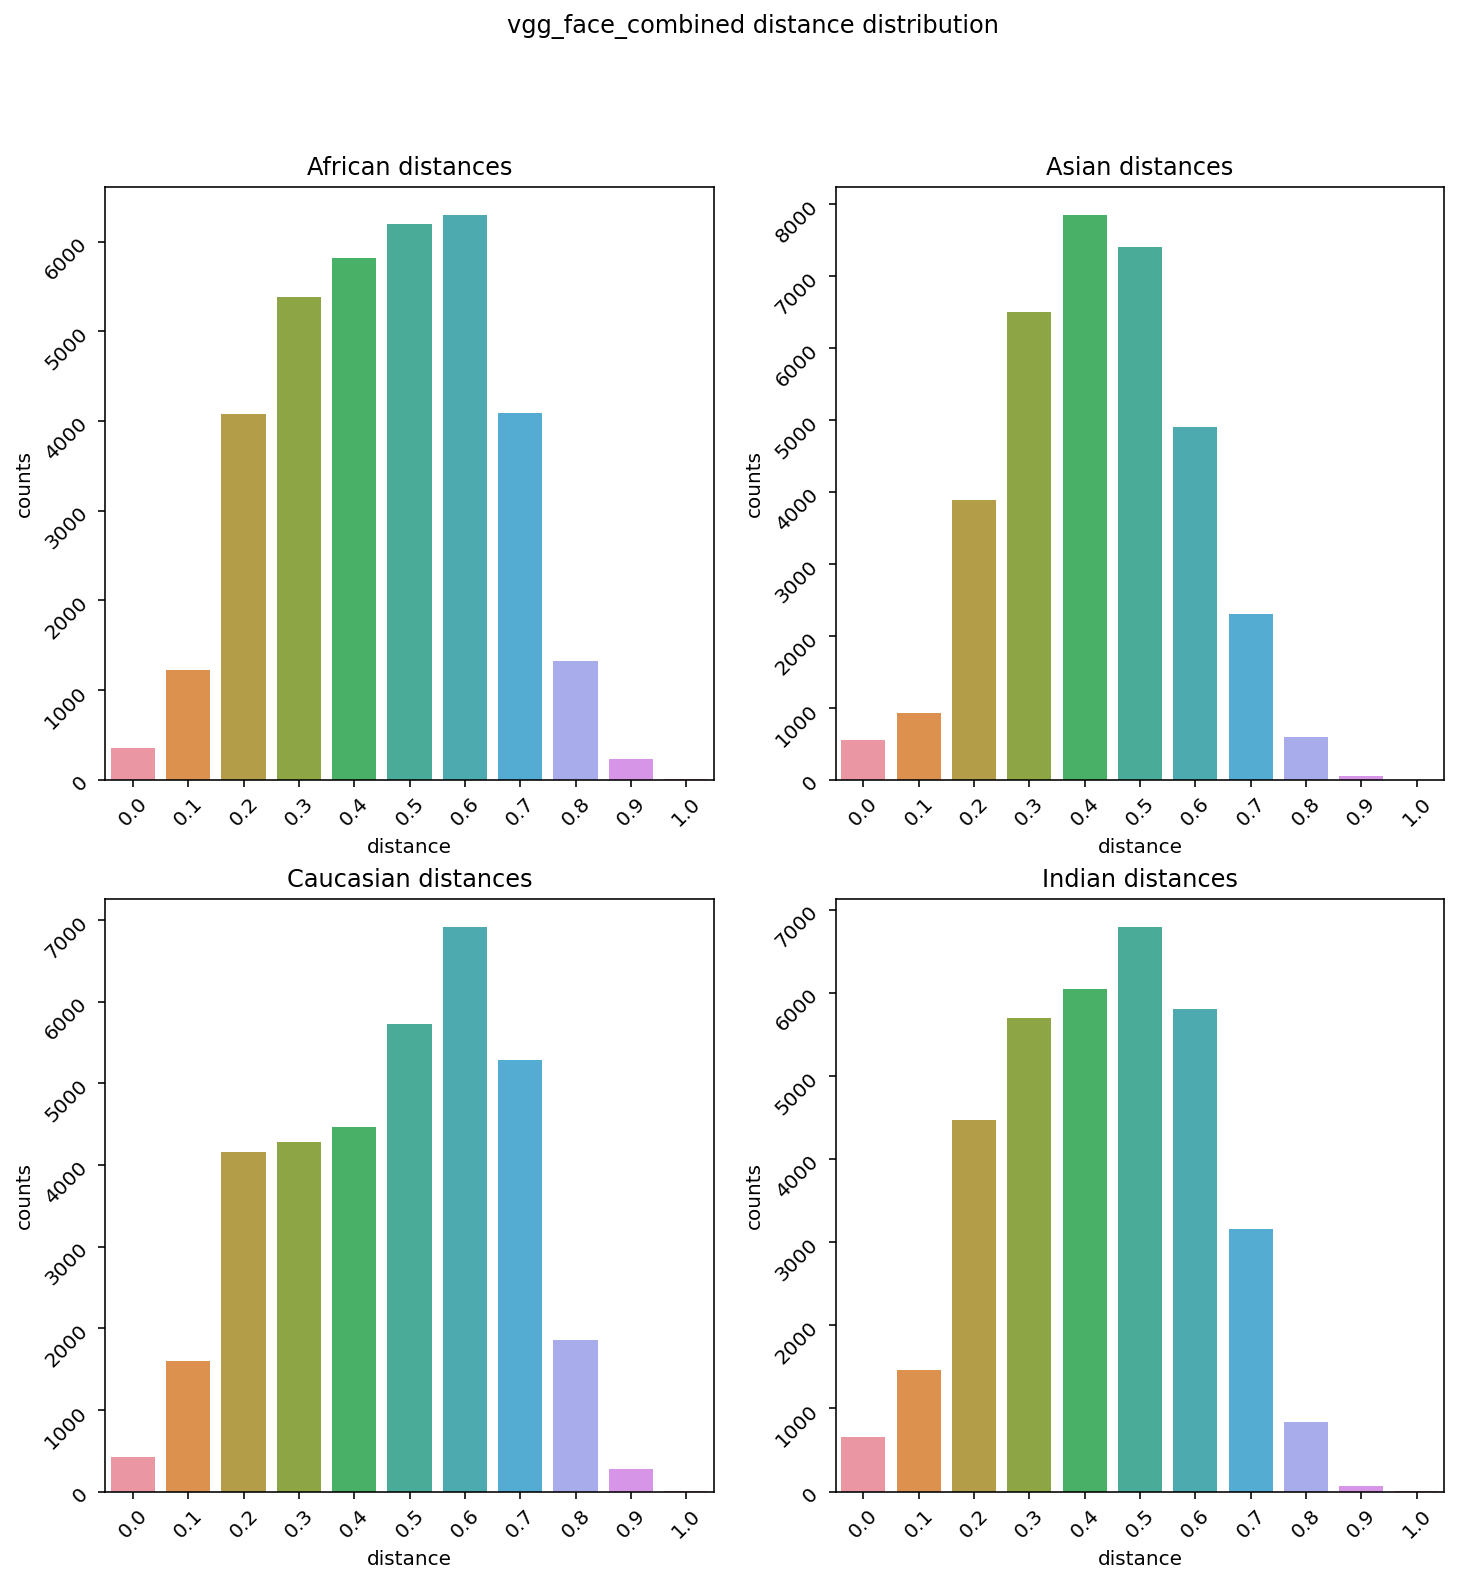

In [23]:
plot_score_distribution(vgg_face_model)

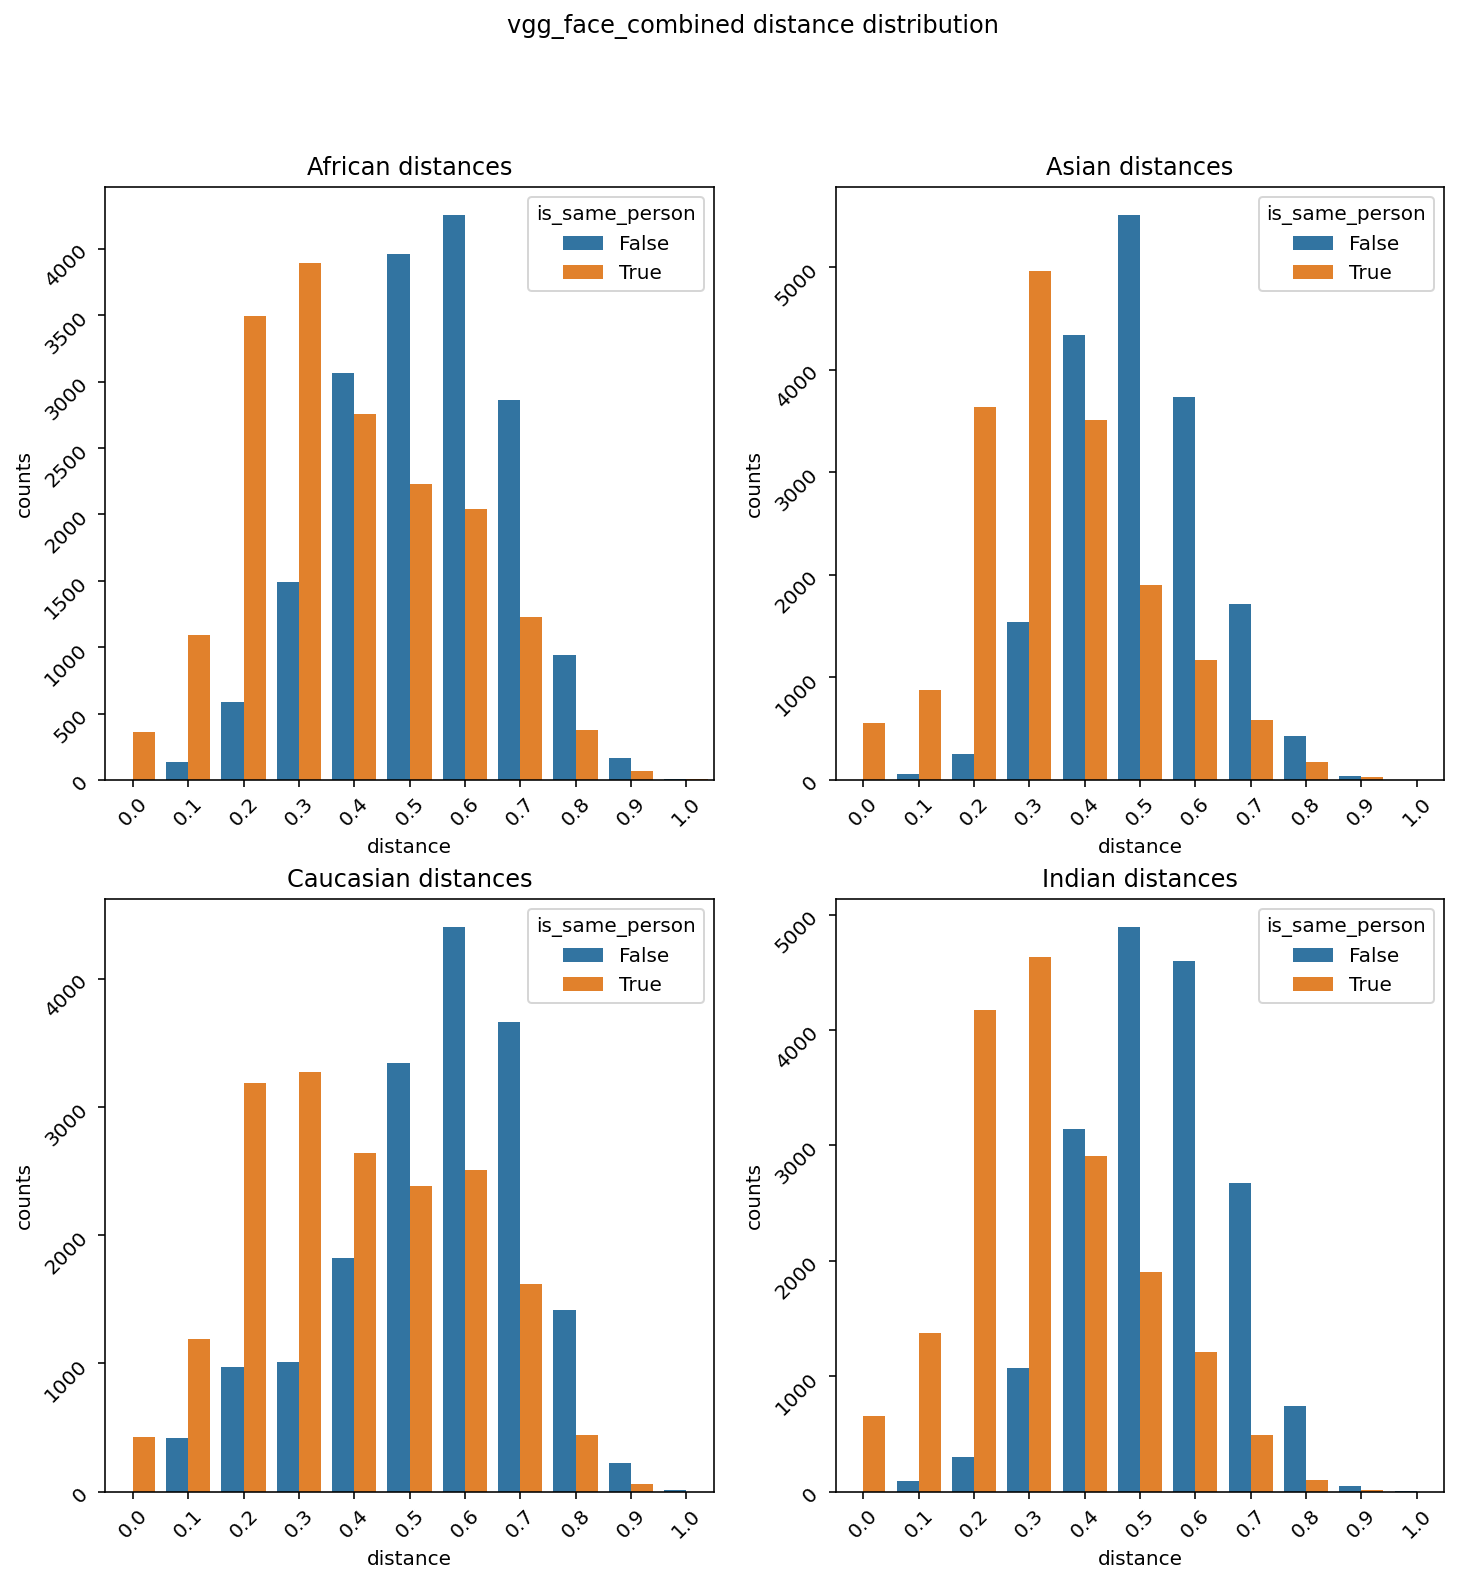

In [24]:
plot_score_distribution(vgg_face_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [25]:
print("Asian difference in mean:",calculate_distribution_difference(vgg_face_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(vgg_face_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(vgg_face_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(vgg_face_model,"Indian"))

Asian difference in mean: -0.15612897165296274
African difference in mean: -0.14990573337651208
Caucasian difference in mean: -0.15923578430370788
Indian difference in mean: -0.21846738074936312


**Results**:
* No spikes in any ethnic group indicating bad discrimination.
* Even heavier overlaps = worse performance

### ArcFace

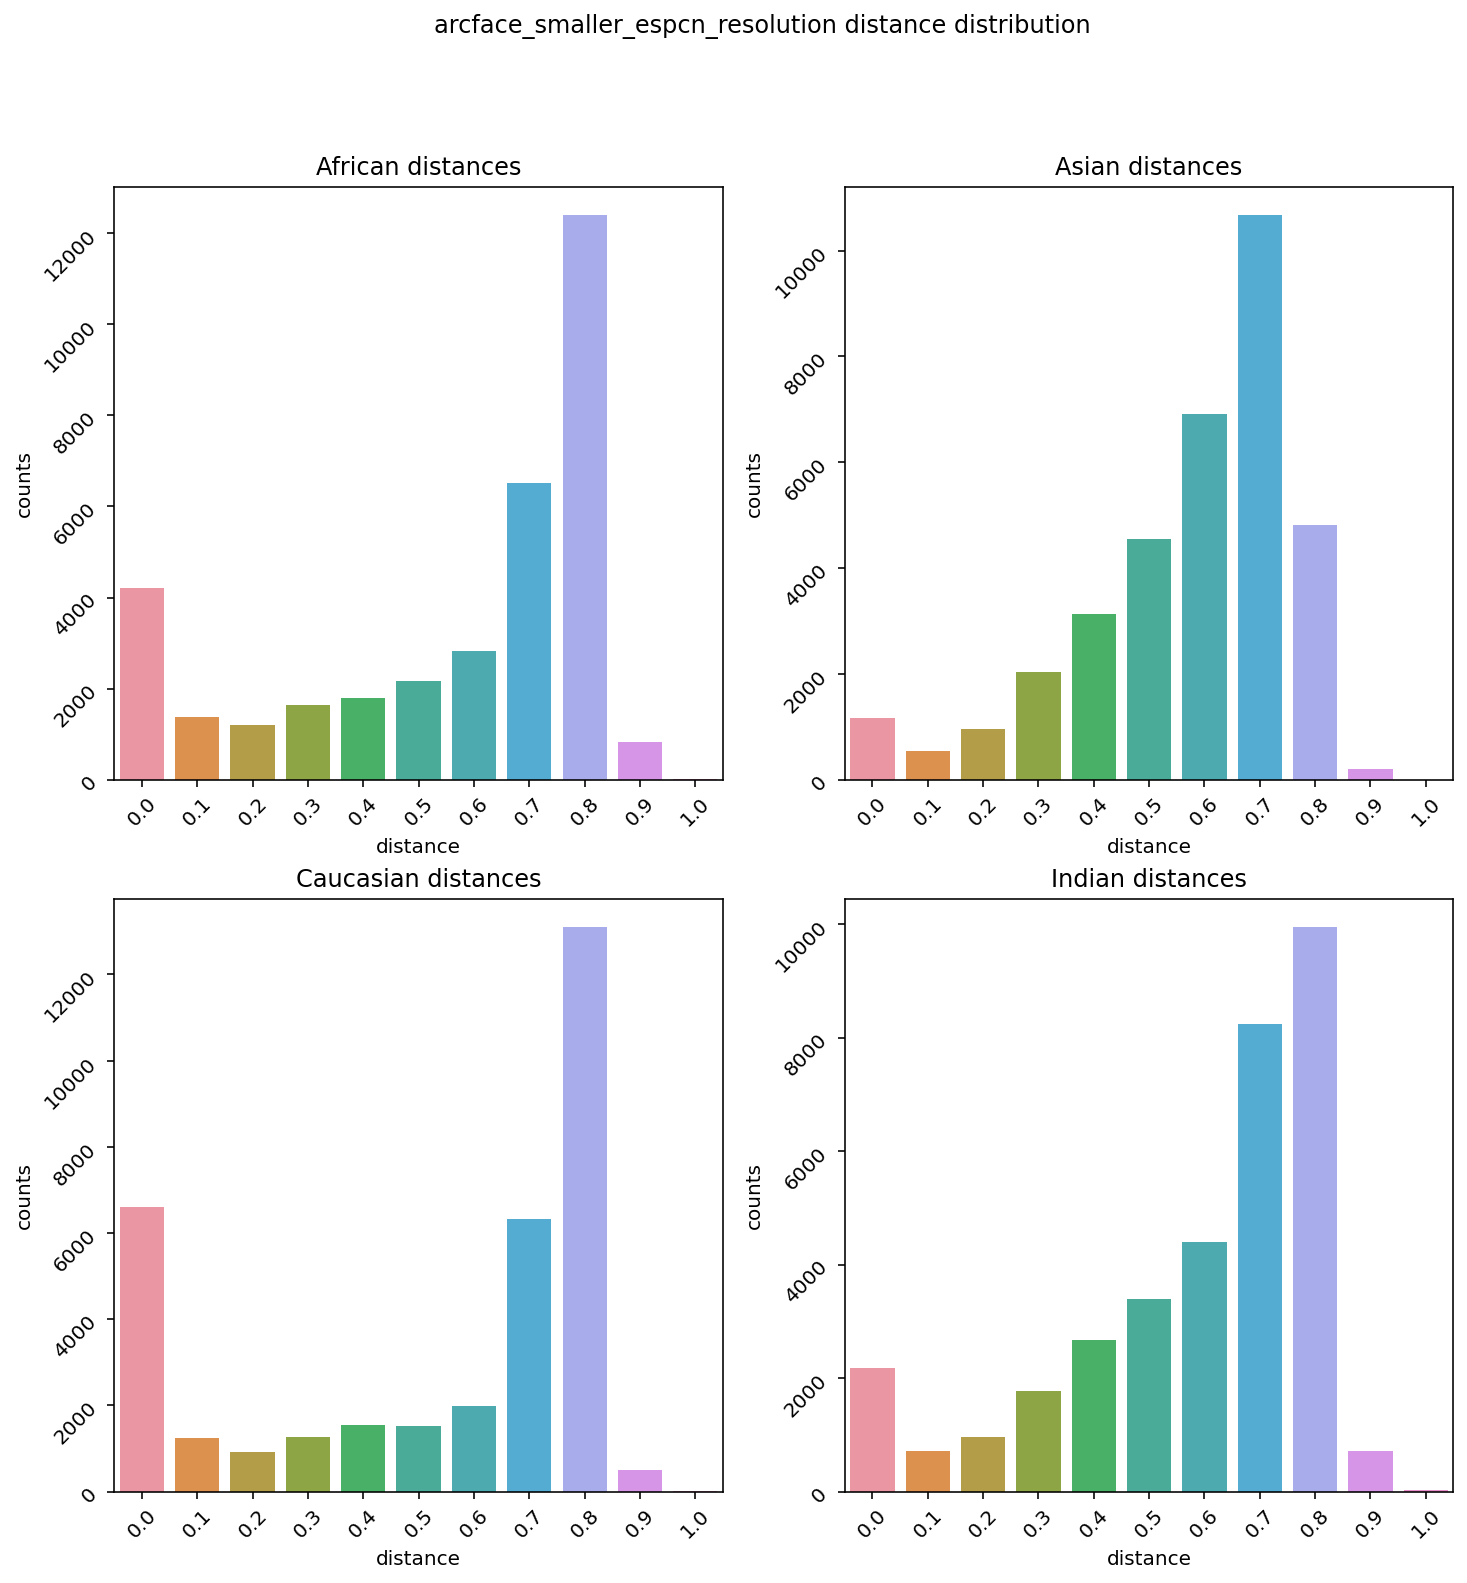

In [26]:
plot_score_distribution(arcface_model)

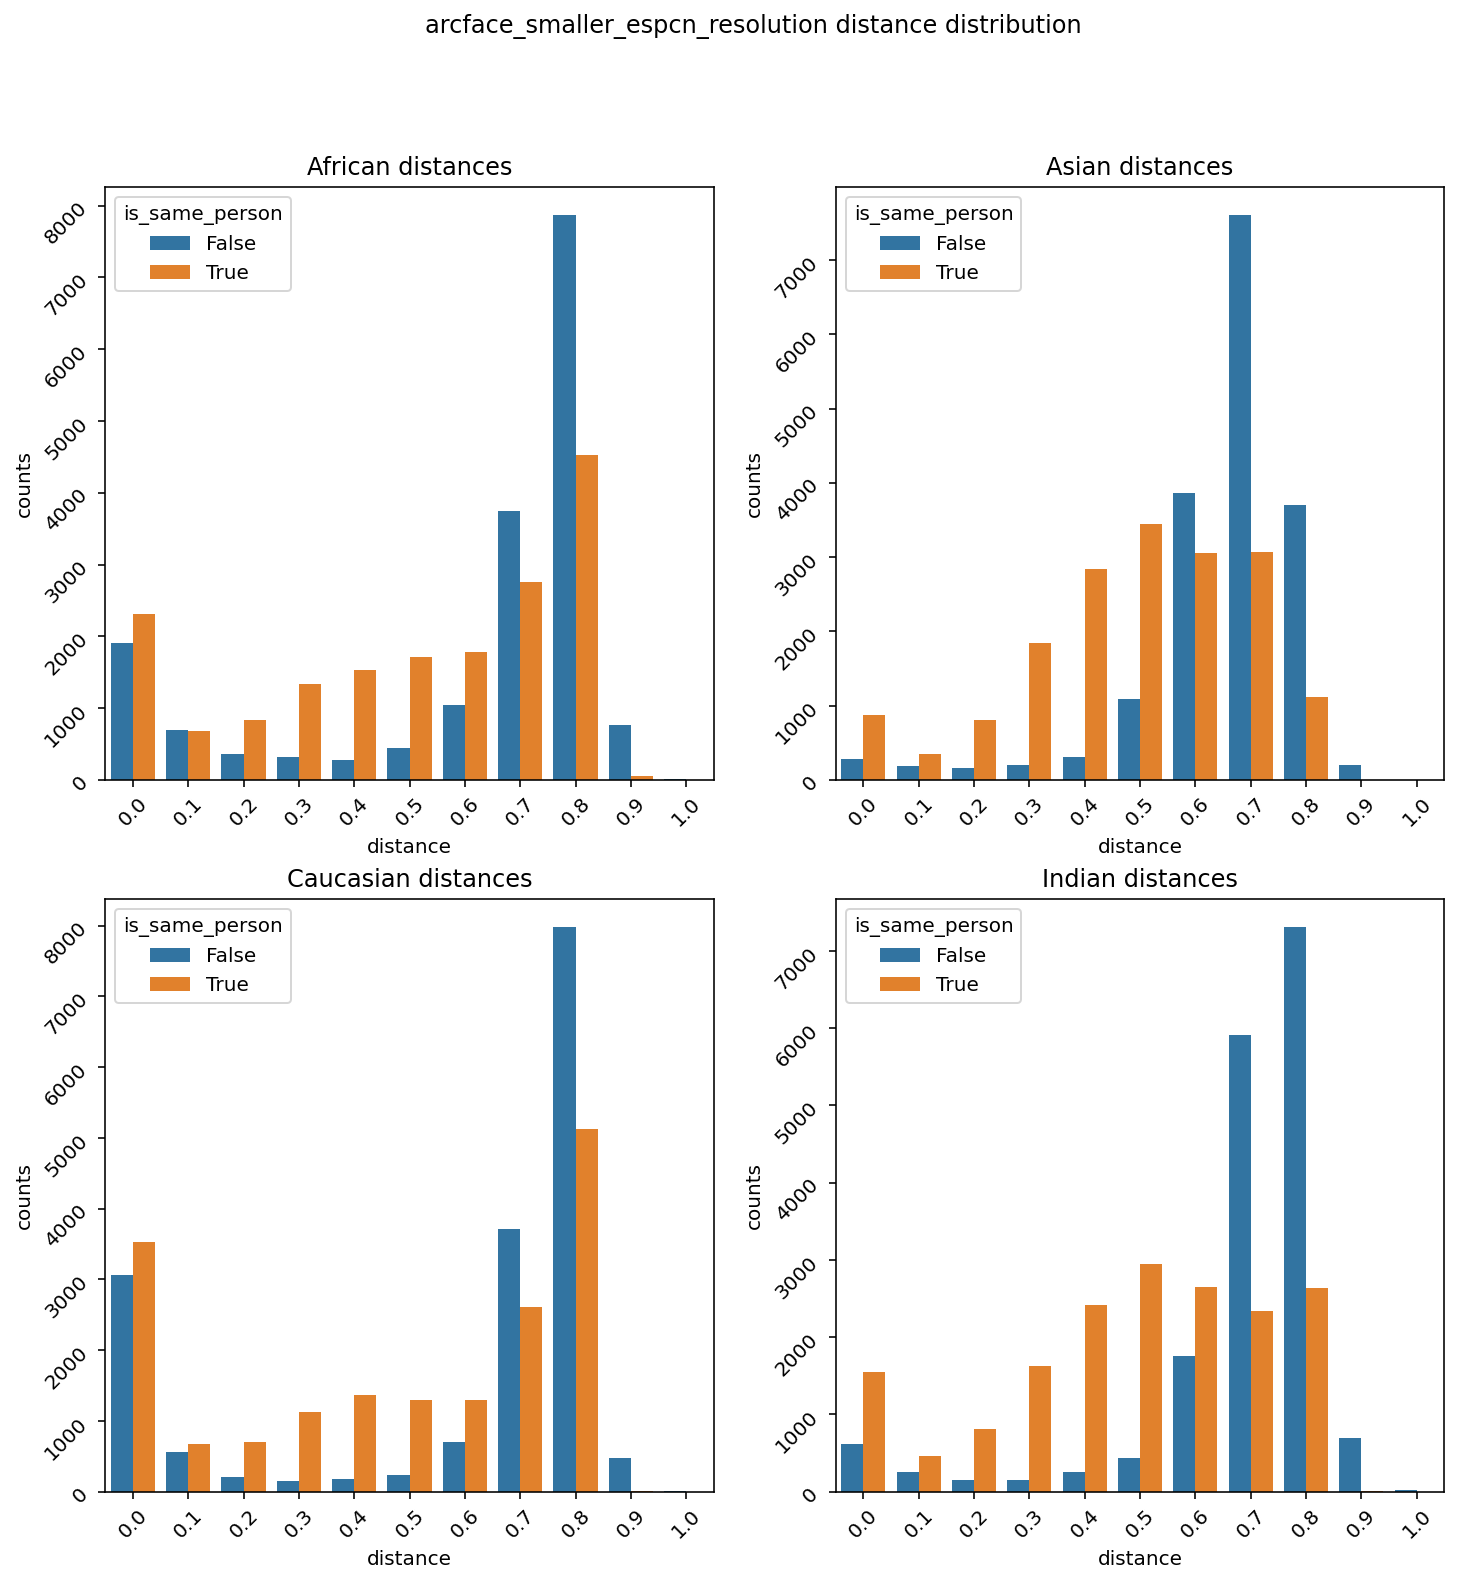

In [27]:
plot_score_distribution(arcface_model,groupby=['distance', 'is_same_person'], hue='is_same_person')

In [28]:
print("Asian difference in mean:",calculate_distribution_difference(arcface_model,"Asian"))
print("African difference in mean:",calculate_distribution_difference(arcface_model,"African"))
print("Caucasian difference in mean:",calculate_distribution_difference(arcface_model,"Caucasian"))
print("Indian difference in mean:",calculate_distribution_difference(arcface_model,"Indian"))

Asian difference in mean: -0.2191694159020341
African difference in mean: -0.14910328114339388
Caucasian difference in mean: -0.14099826187864917
Indian difference in mean: -0.254278508022864


**Results**:
* For all groups there are one or two spikes around 0.7 & 0.8
* Also the amount of non-pairs with 0 distance is significantly higher
* The distance of pairs is partly uniformly distributed (see African distances)
* Almost no discrimination power
* Generally big shift to the higher distances, might be due to geometric approach of ArcFace

## Paired significance tests

Usually a paired t-test would be the desired solution. However the normal distribution of the target variable is not fulfilled which is why we will go with a Wilcoxon-Signed-Rank-Test which is slightly less effective but has less assumptions.

The goal is to investigate if there are significant differences in the mean of the ethnic groups produced by a model. An unbiased model would present similar results. The two-sided test has the null hypothesis that the median of the differences is zero against the alternative that it is different from zero.

For independent sample we will use the Wilcoxon-RankSum-Test (NUll hypothesis = the observations come from the same population).

### General

The first step is to generate all possible combinations of comparisons

In [29]:
def perform_significance_test(model1, model2, ethnic, test_type = st.wilcoxon):
    data1 = pd.DataFrame()
    data2 = pd.DataFrame()
    for j in range(1,6):
        with open(f'results/{model1}/{ethnic}/result_dict{j}.pickle', "rb") as f:
                results = pickle.load(f)
        data_temp = results['data']
        data1 = data1.append(data_temp)
        
        with open(f'results/{model2}/{ethnic}/result_dict{j}.pickle', "rb") as f:
                results = pickle.load(f)
        data_temp = results['data']
        data2 = data2.append(data_temp)        

    return test_type(data1.distance, data2.distance)


In [30]:
ethnic_groups = ["Caucasian", "Asian", "African", "Indian"]

### FaceNet512

In [31]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance:",perform_significance_test("facenet", facenet_model, ethnic)[1])

Wilcoxon test on Caucasian performance: 1.1116665290795733e-95
Wilcoxon test on Asian performance: 1.3927187015412541e-31
Wilcoxon test on African performance: 2.704950738921483e-166
Wilcoxon test on Indian performance: 8.285813535642728e-95


**Results**:
* Testing all combinations lets us reject all null hypothesises

### VGG-Face

In [32]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance: ",perform_significance_test("vgg_face", vgg_face_model, ethnic)[1])

Wilcoxon test on Caucasian performance:  1.0800115551253305e-17
Wilcoxon test on Asian performance:  4.665416992019759e-58
Wilcoxon test on African performance:  6.371753071455191e-61
Wilcoxon test on Indian performance:  2.0808023259281532e-85


**Results**:
* Testing all combinations lets us reject all null hypothesises

### ArcFace

In [33]:
for ethnic in ethnic_groups:
    print(f"Wilcoxon test on {ethnic} performance: ",perform_significance_test("arcface", arcface_model, ethnic)[1])

Wilcoxon test on Caucasian performance:  3.712782780588034e-151
Wilcoxon test on Asian performance:  2.095589770147348e-37
Wilcoxon test on African performance:  8.413091520777684e-69
Wilcoxon test on Indian performance:  1.654888300762449e-18


**Results**:
* Testing all combinations lets us reject all null hypothesises

## Image description with Lime

Differnent models identify different areas in an image as important. Here we want to compare which areas are important to which model.

Ideally the ethic groups should be described similarly.

### General

In [34]:
asian_img_path ='data/race_per_7000/Asian/m.03cfpv1/000050_00@en.jpg'
african_img_path = 'data/race_per_7000/African/m.03v416/32-FaceId-0_align.jpg'
caucasian_img_path = 'data/race_per_7000/Caucasian/m.0356k8/26-FaceId-0_align.jpg'
indian_img_path = 'data/race_per_7000/Indian/m.0l8nmsx/000016_00@hi.jpg'

### FaceNet512

In [35]:
def load_image(shape,path,preprocessing = None):
    if preprocessing is not None:
        img = Image.open(path)
        img = np.array(img)
        img = preprocessing(img)
        img = cv2.resize(img, dsize=shape, interpolation=cv2.INTER_CUBIC) 
    else:
        img = Image.open(path).resize(shape)
        img = np.array(img)
    return img

In [37]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(160,160), preprocessing = increase_espcn_resolution_and_denoise)
african_img = load_image(path=african_img_path,shape=(160,160), preprocessing = increase_espcn_resolution_and_denoise)
caucasian_img = load_image(path=caucasian_img_path,shape=(160,160), preprocessing = increase_espcn_resolution_and_denoise)
indian_img = load_image(path=indian_img_path,shape=(160,160), preprocessing = increase_espcn_resolution_and_denoise)

In [38]:
facenet512 = DeepFace.build_model("Facenet512")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 21.938795260073828
Prediction_local [12.49766766]
Right: 12.326255
Intercept 24.265935832865992
Prediction_local [13.91154005]
Right: 13.773624


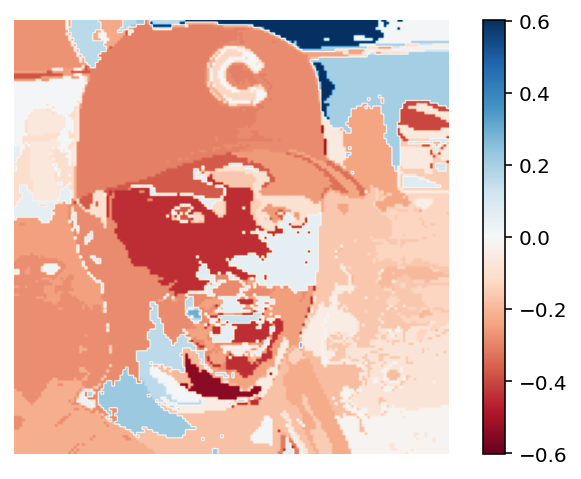

In [39]:
plot_face_heatmap(facenet512, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 31.067526570715845
Prediction_local [19.96675671]
Right: 19.67119
Intercept 25.633730155191024
Prediction_local [19.84985185]
Right: 19.728222


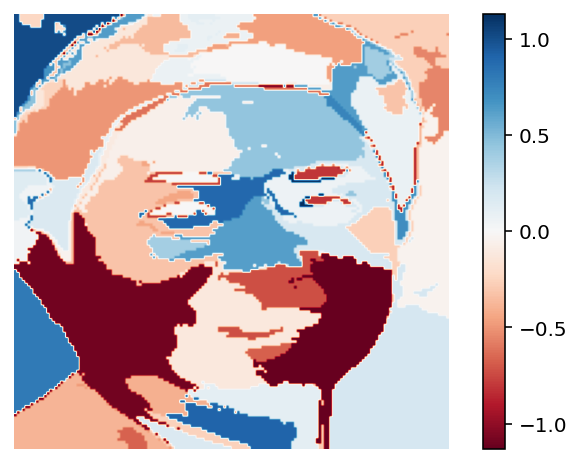

In [40]:
plot_face_heatmap(facenet512, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 21.88440293948735
Prediction_local [10.7342894]
Right: 10.368948
Intercept 16.224816189733012
Prediction_local [10.98511816]
Right: 10.775292


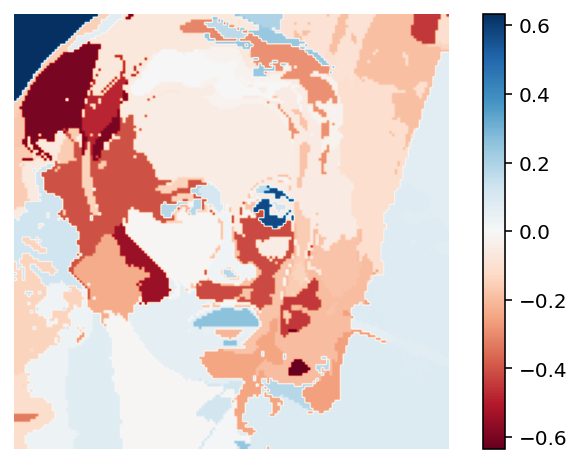

In [41]:
plot_face_heatmap(facenet512, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 33.69275201343531
Prediction_local [16.82058574]
Right: 16.532059
Intercept 24.98330581066442
Prediction_local [16.87708218]
Right: 16.769846


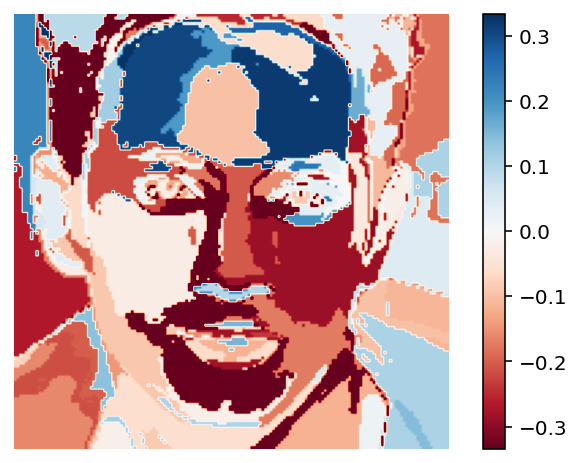

In [42]:
plot_face_heatmap(facenet512, indian_img)

### VGG-Face

In [43]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(224,224), preprocessing = increase_espcn_resolution_and_denoise)
african_img = load_image(path=african_img_path,shape=(224,224), preprocessing = increase_espcn_resolution_and_denoise)
caucasian_img = load_image(path=caucasian_img_path,shape=(224,224), preprocessing = increase_espcn_resolution_and_denoise)
indian_img = load_image(path=indian_img_path,shape=(224,224), preprocessing = increase_espcn_resolution_and_denoise)

In [44]:
vgg_face = DeepFace.build_model("VGG-Face")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -0.8824307081314489
Prediction_local [10.63814028]
Right: 10.762649
Intercept -3.1489528802511124
Prediction_local [11.79299501]
Right: 11.995261


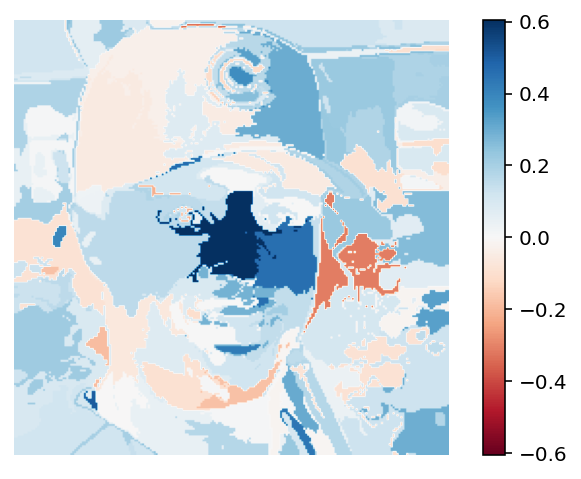

In [45]:
plot_face_heatmap(vgg_face, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -0.9606013705972156
Prediction_local [10.59122635]
Right: 10.762649
Intercept -3.5603150003130075
Prediction_local [11.76295694]
Right: 11.995261


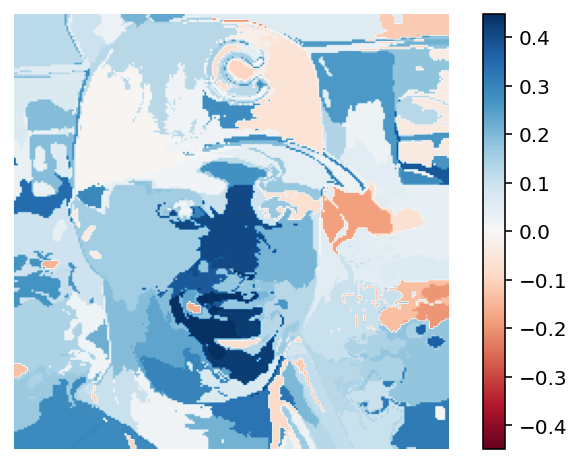

In [46]:
plot_face_heatmap(vgg_face, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -2.2874272247366756
Prediction_local [15.17428442]
Right: 15.540931
Intercept -3.4706123967098437
Prediction_local [15.81542831]
Right: 16.256119


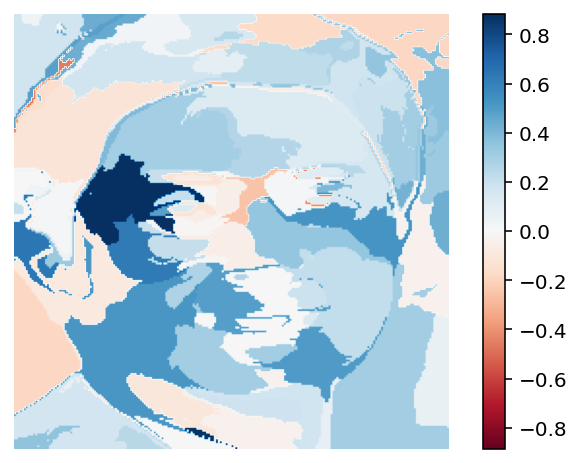

In [47]:
plot_face_heatmap(vgg_face, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -15.136220402707858
Prediction_local [19.66510464]
Right: 20.399363
Intercept -13.318269996948116
Prediction_local [20.27302734]
Right: 20.986841


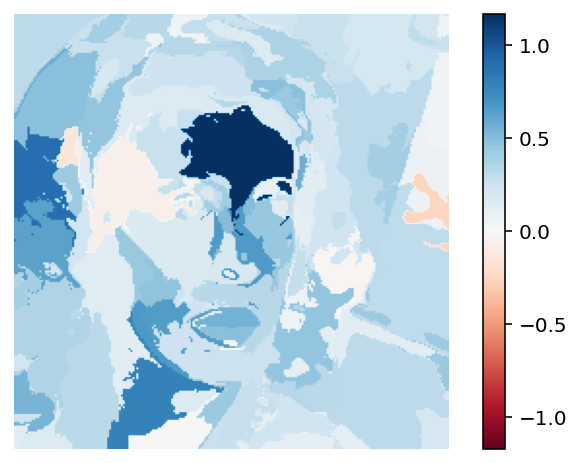

In [48]:
plot_face_heatmap(vgg_face, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept -2.3920452422742846
Prediction_local [11.08713067]
Right: 11.224414
Intercept -4.974065572905431
Prediction_local [11.74301698]
Right: 11.935747


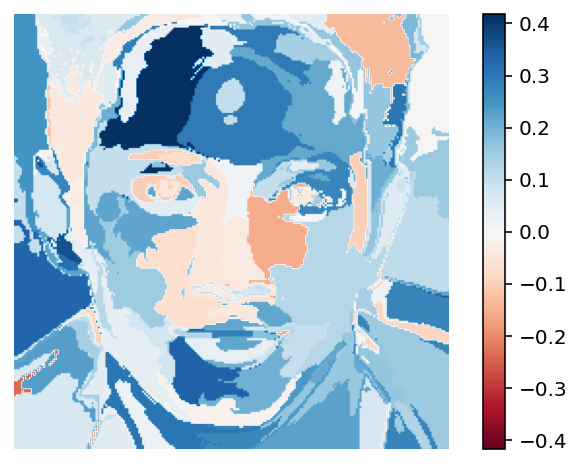

In [49]:
plot_face_heatmap(vgg_face, indian_img)

### ArcFace

In [50]:
# get example image
asian_img = load_image(path=asian_img_path,shape=(112,112), preprocessing = increase_espcn_resolution_and_denoise)
african_img = load_image(path=african_img_path,shape=(112,112), preprocessing = increase_espcn_resolution_and_denoise)
caucasian_img = load_image(path=caucasian_img_path,shape=(112,112), preprocessing = increase_espcn_resolution_and_denoise)
indian_img = load_image(path=indian_img_path,shape=(112,112), preprocessing = increase_espcn_resolution_and_denoise)

In [51]:
arcface = DeepFace.build_model("ArcFace")

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 336.25266429660957
Prediction_local [972.95765036]
Right: 988.6431
Intercept 506.8747449747012
Prediction_local [1197.71960949]
Right: 1218.9106


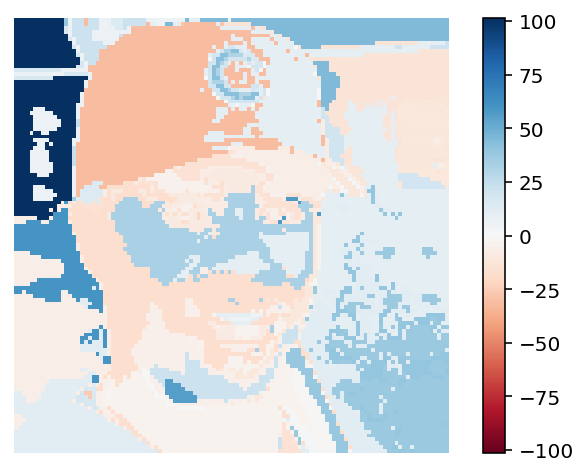

In [52]:
plot_face_heatmap(arcface, african_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 1174.0120901716598
Prediction_local [1534.39407376]
Right: 1514.273
Intercept 331.33283674699874
Prediction_local [1781.75531367]
Right: 1818.3683


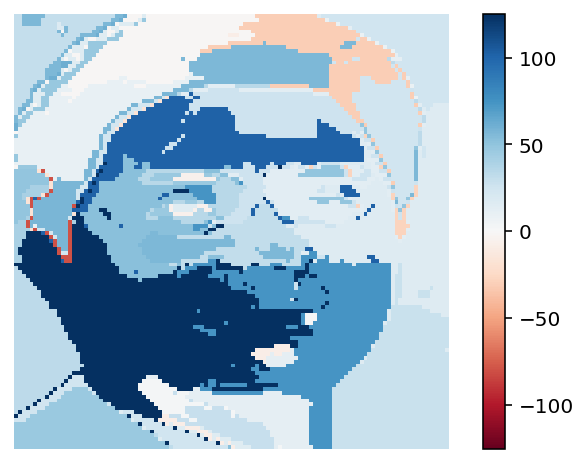

In [53]:
plot_face_heatmap(arcface, asian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 341.0440466280157
Prediction_local [907.22339963]
Right: 918.6041
Intercept 578.3189011555003
Prediction_local [1148.6370524]
Right: 1162.1265


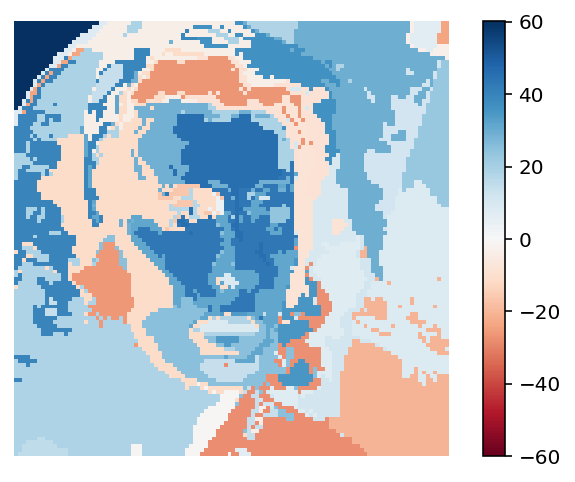

In [54]:
plot_face_heatmap(arcface, caucasian_img)

  0%|          | 0/30 [00:00<?, ?it/s]

Intercept 610.2275691419549
Prediction_local [1108.21973917]
Right: 1111.3414
Intercept 973.7013603097628
Prediction_local [1473.48234608]
Right: 1474.5302


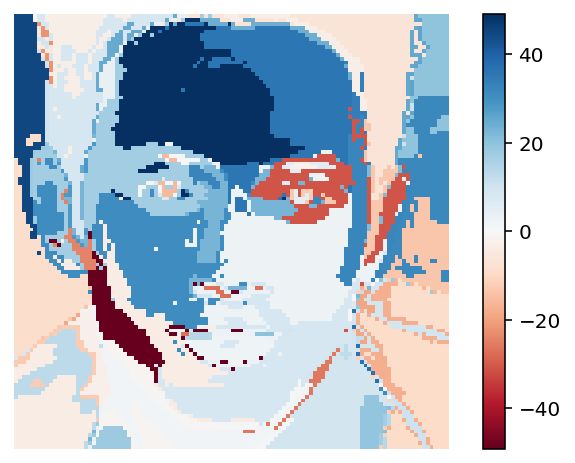

In [55]:
plot_face_heatmap(arcface, indian_img)

**Results**:
* Caucasian image has important forehead on all models
* ArcFace does not detect same face patterns for African as others